Import thư viện và Cấu hình

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Cấu hình đường dẫn (Phải khớp với file train cũ)
INPUT_FILE = '../../data/IRIS_cleaned.csv'
MODEL_FILE = '../models/softmax_model.pkl'

# Định nghĩa lại hàm Softmax để dùng cho dự đoán
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

print("Đã import thư viện thành công!")

Đã import thư viện thành công!


Hàm Load Model và Hàm Dự Đoán

In [2]:
def load_model(filepath):
    try:
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        print(f"--> Đã load model thành công!")
        print(f"--> Thông tin: {model_data.get('info', 'N/A')}")
        print(f"--> Các lớp: {model_data['classes']}")
        return model_data
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file model tại {filepath}. Hãy chạy train trước!")
        return None

def predict(model_data, X):
    W = model_data['weights']
    b = model_data['bias']
    
    # Tính toán Forward pass: Z = X.W + b
    z = np.dot(X, W) + b
    
    # Tính xác suất
    y_hat = softmax(z)
    
    # Lấy nhãn có xác suất cao nhất
    return np.argmax(y_hat, axis=1)

# Thực hiện load model
model = load_model(MODEL_FILE)

--> Đã load model thành công!
--> Thông tin: Softmax Regression from scratch
--> Các lớp: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


Chuẩn bị dữ liệu Test

In [3]:
def load_test_data(filename, train_ratio=0.8):
    try:
        df = pd.read_csv(filename)
        # Shuffle giống hệt file train (random_state=42) để đảm bảo tập test khớp nhau
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Tách tập Test (20% cuối)
        split_idx = int(len(df) * train_ratio)
        df_test = df.iloc[split_idx:].copy()
        
        # Tách X và y
        X_test = df_test.iloc[:, :4].values
        y_labels = df_test.iloc[:, -1].values
        
        return df_test, X_test, y_labels
    except FileNotFoundError:
        print("Không tìm thấy file data!")
        return None, None, None

# Load dữ liệu
df_test_org, X_test, y_test_labels = load_test_data(INPUT_FILE)

# Chuyển đổi nhãn text sang số (index) dựa trên thứ tự lớp trong model
if model:
    CLASS_ORDER = model['classes']
    y_test_indices = np.array([CLASS_ORDER.index(label) for label in y_test_labels])
    
    print(f"Số lượng mẫu kiểm thử: {len(X_test)}")

Số lượng mẫu kiểm thử: 30


Thực hiện Dự đoán và Báo cáo Hiệu suất

In [4]:
if model:
    # 1. Dự đoán
    y_pred_indices = predict(model, X_test)
    
    # 2. Tính độ chính xác (Accuracy)
    accuracy = np.mean(y_pred_indices == y_test_indices) * 100
    
    # 3. Chuyển chỉ số dự đoán ngược lại thành tên hoa
    y_pred_labels = [CLASS_ORDER[idx] for idx in y_pred_indices]

    # 4. Tạo DataFrame báo cáo
    results = pd.DataFrame({
        'Sepal Length': X_test[:, 0],
        'Sepal Width': X_test[:, 1],
        'Petal Length': X_test[:, 2],
        'Petal Width': X_test[:, 3],
        'Thực tế': y_test_labels,
        'Dự đoán': y_pred_labels
    })
    
    # Đánh dấu đúng/sai
    results['Kết quả'] = np.where(results['Thực tế'] == results['Dự đoán'], 'ĐÚNG', 'SAI')
    
    print(f"=== BÁO CÁO HIỆU SUẤT ===")
    print(f"Độ chính xác trên tập Test: {accuracy:.2f}%")
    print("\nChi tiết 10 mẫu đầu tiên:")
    print(results.head(10))
    
    # Đếm số lượng sai
    wrong_cases = results[results['Kết quả'] == 'SAI']
    print(f"\nTổng số mẫu dự đoán sai: {len(wrong_cases)}")

=== BÁO CÁO HIỆU SUẤT ===
Độ chính xác trên tập Test: 96.67%

Chi tiết 10 mẫu đầu tiên:
   Sepal Length  Sepal Width  Petal Length  Petal Width          Thực tế  \
0      0.500000     0.416667      0.610169     0.541667  Iris-versicolor   
1      0.055556     0.125000      0.050847     0.083333      Iris-setosa   
2      0.638889     0.375000      0.610169     0.500000  Iris-versicolor   
3      0.333333     0.250000      0.576271     0.458333  Iris-versicolor   
4      0.277778     0.708333      0.084746     0.041667      Iris-setosa   
5      0.361111     0.416667      0.525424     0.500000  Iris-versicolor   
6      0.833333     0.375000      0.898305     0.708333   Iris-virginica   
7      0.666667     0.541667      0.796610     0.833333   Iris-virginica   
8      0.222222     0.708333      0.084746     0.125000      Iris-setosa   
9      0.166667     0.166667      0.389831     0.375000  Iris-versicolor   

           Dự đoán Kết quả  
0  Iris-versicolor    ĐÚNG  
1      Iris-setos

Ma trận Tương quan (Correlation Matrix)

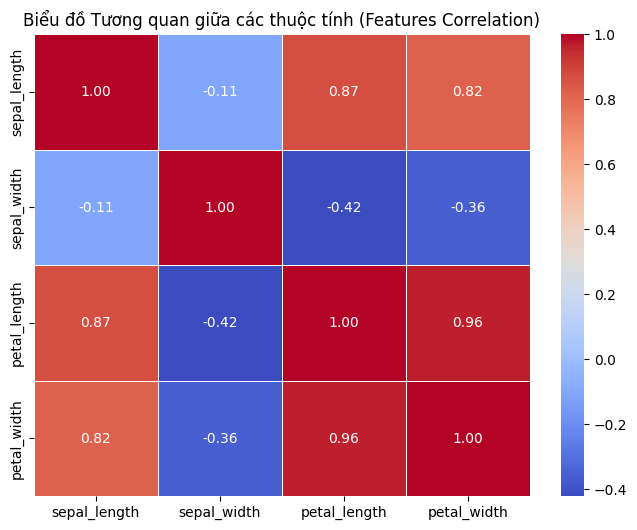

In [5]:
# Tải lại toàn bộ dữ liệu để xem tương quan tổng quát
df_full = pd.read_csv(INPUT_FILE)

# Chỉ lấy 4 cột đặc trưng số
df_features = df_full.iloc[:, :4]

# Tính ma trận tương quan
corr_matrix = df_features.corr()

# Vẽ Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Biểu đồ Tương quan giữa các thuộc tính (Features Correlation)')
plt.show()

Confusion Matrix (So sánh Thực tế vs Dự đoán)

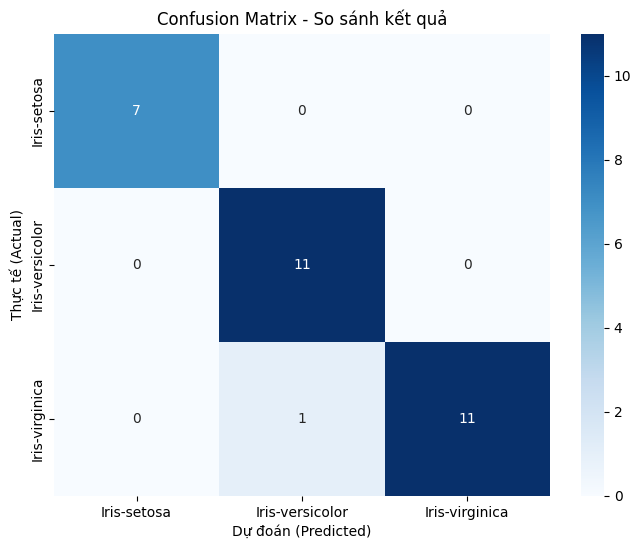

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

if model:
    # Tạo Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=CLASS_ORDER)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_ORDER, yticklabels=CLASS_ORDER)
    plt.xlabel('Dự đoán (Predicted)')
    plt.ylabel('Thực tế (Actual)')
    plt.title('Confusion Matrix - So sánh kết quả')
    plt.show()

Trực quan hóa lỗi sai (Scatter Plot)

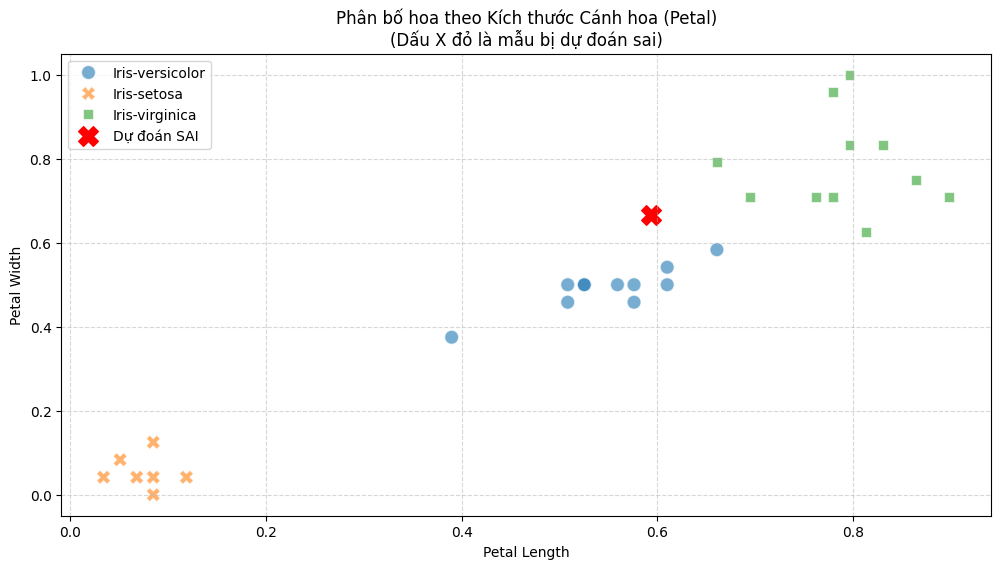

In [7]:
if model:
    plt.figure(figsize=(12, 6))
    
    # Dữ liệu đúng
    correct_data = results[results['Kết quả'] == 'ĐÚNG']
    # Dữ liệu sai
    wrong_data = results[results['Kết quả'] == 'SAI']

    # Vẽ các điểm đúng
    sns.scatterplot(data=correct_data, x='Petal Length', y='Petal Width', 
                    hue='Thực tế', style='Thực tế', s=100, alpha=0.6)
    
    # Vẽ các điểm sai (đánh dấu X màu đỏ nổi bật)
    if not wrong_data.empty:
        plt.scatter(wrong_data['Petal Length'], wrong_data['Petal Width'], 
                    color='red', s=200, marker='X', label='Dự đoán SAI')

    plt.title('Phân bố hoa theo Kích thước Cánh hoa (Petal)\n(Dấu X đỏ là mẫu bị dự đoán sai)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()